(battery)=
# Bayesian Decision Theory: should I buy a house battery?

:::{post} Feburary, 2024
:tags: decision making, case study, 
:category: beginner, reference
:author: Benjamin T. Vincent
:::

In [1]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

In [2]:
%config InlineBackend.figure_format = 'retina'  # high resolution figures
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(42)

## Introduction

This case study will focus on the decision of whether to buy a house battery. This will be based on my own personal circumstances, partly because I am currently considering this decision, and partly because I have weekly data on my electricity usage and generation through photovoltaic (PV) panels. 

We will use Bayesian Decision Theory to make the decision of whether to buy a house battery. A decision like this is complex and will involve many factors, but here we will only consider the financial aspects of the decision.

We are going to consider the following scenarios:
1. The status quo: We don't buy a house battery and continue to use electricity as we currently do.
2. Buy a house battery: We spend money upfront with the hope that our ongoing costs will be lower.

There are clearly many variations of the second scenario, such as the size of the battery, the way in which we use it and the choice of tariff. The aim here is not to consider all of these scenarios - we will pick a relatively simple scenario and focus on the process of making the decision.

The approach we will take is to project out the costs of each scenario over the next 10 years (see figure below). We can then estimate the time to break even and also get a sense of the rate at which savings will accrue if we buy a house battery.

![](battery_schematic.jpg)

Clearly, buying a house battery will carry upfront costs, but by estimating the time it takes to recoup these costs, we can make a more informed decision. Because energy use and generation is seasonal, the costs incurred under both scenarios will not be linear. But hopefully this schematic figure gives a good sense of how we will go about making the decision.

### Why buy a house battery?
1. Higher utilisation of solar energy: Rather than exporting any excess electricity to the grid, we could store it in a house battery and use it later. While this would result in less money being made from exporting excess solar energy, it would also mean that we would use less electricity from the grid, which is more expensive.
2. Load shifting: We could use the house battery to store electricity from the grid overnight when it is cheap, and use it when it is more expensive. This would involve moving to a time-of-use tariff, where electricity is more expensive at certain times of day.


We have recently moved into a house which has solar panels on the roof. This means that we generate electricity during the day, and use it at night. We are considering buying a house battery to store the electricity generated during the day, and use it at night.

### Household energy consumption and generation
We use electricity for heating, cooking, lighting, and appliances. We currently have a gas combi boiler for heating and hot water, and so we don't use electricity for heating or hot water, via a heat pump for example. Currently we are on a flat rate tariff, where we pay the same amount for electricity (0.2816 p/kWr) at all times of day. In the UK we also have a daily standing charge. This is a fixed cost that will remain constant regardless of the strategy we take, so we ignore it in our calculations.

The house has 3 solar panels on the roof, which generate electricity during the day. Without a house battery, any energy created by the solar panels is either used by the house or exported to the grid. We are paid for any electricity exported to the grid, but this is at a relatively low rate. We currently get paid 0.15 p/kWhr for electricity exported to the grid.

### Calculating costs

In order to calculate the costs of each scenario, we need to know the following quantities:

$$
\text{cost} = (\text{import rate} \cdot \text{grid import}) - (\text{export rate} \cdot \text{grid export})
$$

$$$$
where:

* $\text{import rate}$ = 0.2816 £/kWr,
* $\text{export rate}$ = 0.15 £/kWr.

The costs calculation may get a little more complex later on in the notebook where we move away from a flat rate tarrif and consider a time of use tarrif with a cheaper night rate.

### Load and process the data

So let's make a start by loading in the data.

In [3]:
try:
    df = pd.read_csv(os.path.join("..", "data", "energy_use.csv"), parse_dates=["date"])
except FileNotFoundError:
    df = pd.read_csv(pm.get_data("energy_use.csv"), parse_dates=["date"])

df.head()

,date,grid_import,grid_export,pv_gen
0,2023-05-21,172,27,46.17
1,2023-05-28,194,39,68.21
2,2023-06-04,213,54,94.21
3,2023-06-11,239,62,111.05
4,2023-06-18,262,79,141.24


Because these are raw meter readings, let's reset these to be zero at the start of the data. This will make the calculations easier.

In [4]:
for col in ["grid_import", "grid_export", "pv_gen"]:
    df[col] = df[col] - df[col].iloc[0]

In [5]:
df.head()

,date,grid_import,grid_export,pv_gen
0,2023-05-21,0,0,0.00
1,2023-05-28,22,12,22.04
2,2023-06-04,41,27,48.04
3,2023-06-11,67,35,64.88
4,2023-06-18,90,52,95.07


The raw data (columns) we have available are:

* `date`: the date on which the reading was taken.
* `grid_import`: the total energy imported from the grid.
* `grid_export`: the total energy exported to the grid.
* `pv_gen`: the total energy generated by the PV system.

In [6]:
IMPORT_RATE = 0.2816
EXPORT_RATE = 0.15

We'll also benefit from calculating the time between the measurements and creating a column representing the week of the year.

In [7]:
# calculate time sinse last reading
df["tdelta"] = df["date"].diff()
# calculate week of year
df["week"] = df["date"].dt.isocalendar().week

df.set_index("date", inplace=True)

We can also derive a few other useful quantities:
* We can calculate the energy used by the house from the PV (i.e. not exported to the grid) as: $\text{PV used} = \text{PV gen} - \text{grid export}$.
* We can calculate the total household energy use as: $\text{total use} = \text{grid import} + \text{PV used}$.

In [8]:
df["pv_used"] = df["pv_gen"] - df["grid_export"]
df["total_demand"] = df["grid_import"] + df["pv_used"]

In [9]:
df["cost"] = IMPORT_RATE * df["total_demand"] - EXPORT_RATE * df["grid_export"]

So now our dataset looks like this:

In [10]:
df.head()

,grid_import,grid_export,pv_gen,tdelta,week,pv_used,total_demand,cost
date,,,,,,,,
2023-05-21,0,0,0.00,NaT,20,0.00,0.00,0.000000
2023-05-28,22,12,22.04,7 days,21,10.04,32.04,7.222464
2023-06-04,41,27,48.04,7 days,22,21.04,62.04,13.420464
2023-06-11,67,35,64.88,7 days,23,29.88,96.88,22.031408
2023-06-18,90,52,95.07,7 days,24,43.07,133.07,29.672512


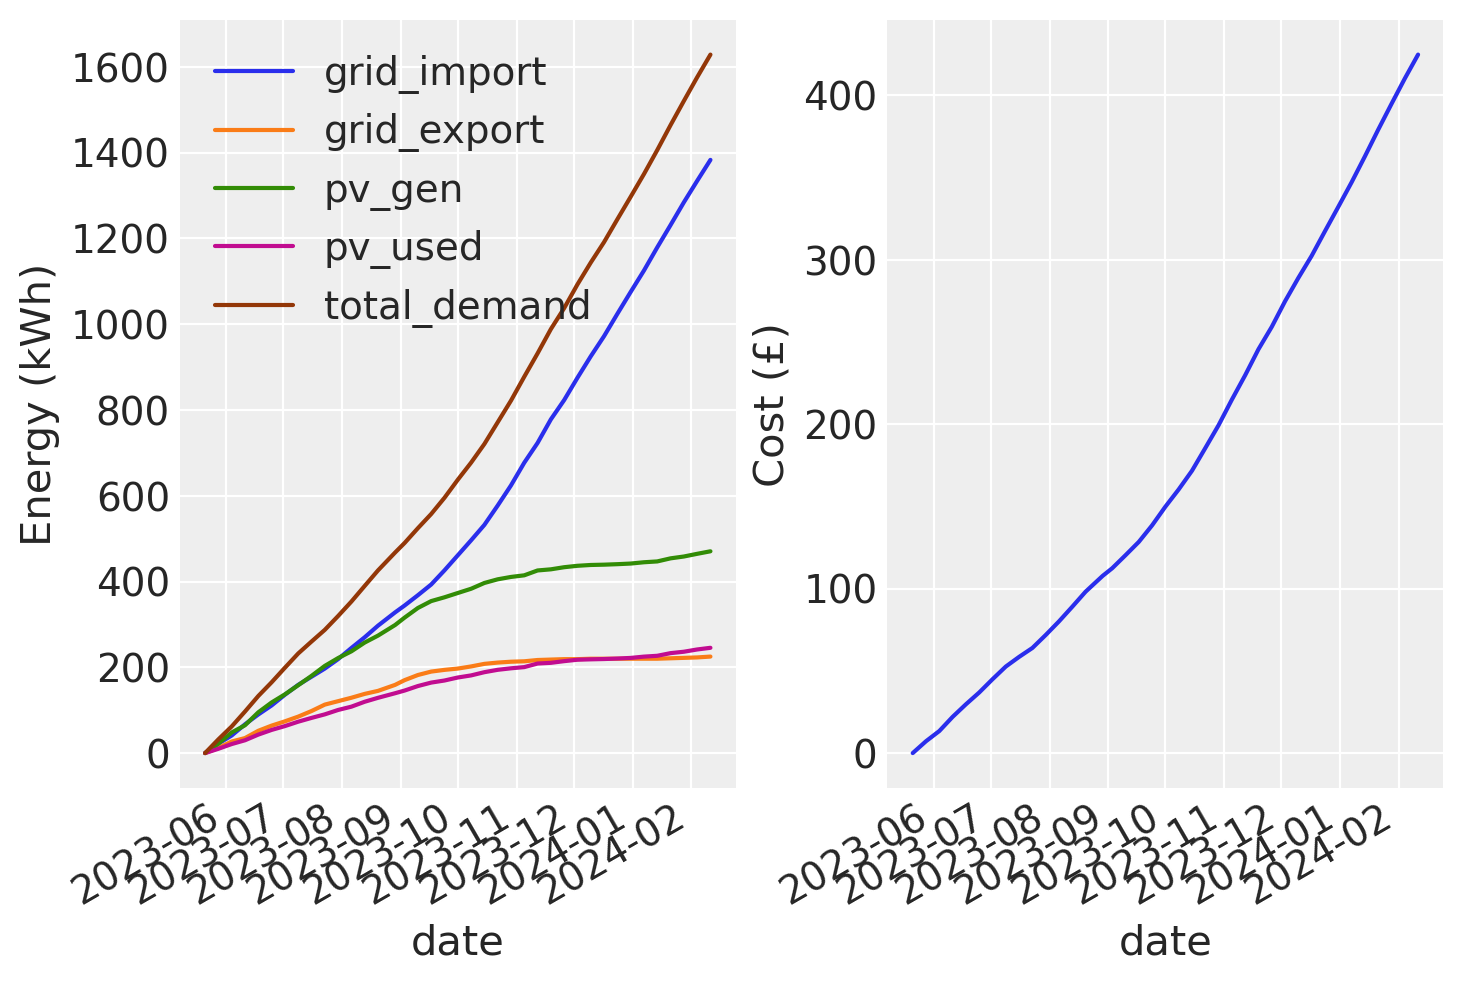

In [11]:
fig, ax = plt.subplots(1, 2)
df[["grid_import", "grid_export", "pv_gen", "pv_used", "total_demand"]].plot(ax=ax[0])
ax[0].set_ylabel("Energy (kWh)")

df["cost"].plot(ax=ax[1])
ax[1].set_ylabel("Cost (£)");

So far we've imported our raw data, calculated a number important quantities from that, and calculated the financial costs of the current strategy. Importantly, this data is from the past and we have less than a year's worth of data.

## Forecasting cost of the status quo into the future

Let's use our historical data to forecast both the energy demand and the PV generation into the future. We can then use these forecasts to calculate the costs of the status quo into the future.

**TODO: normalise the data to get in units of kWhr/day. This is currently kWh/week.**

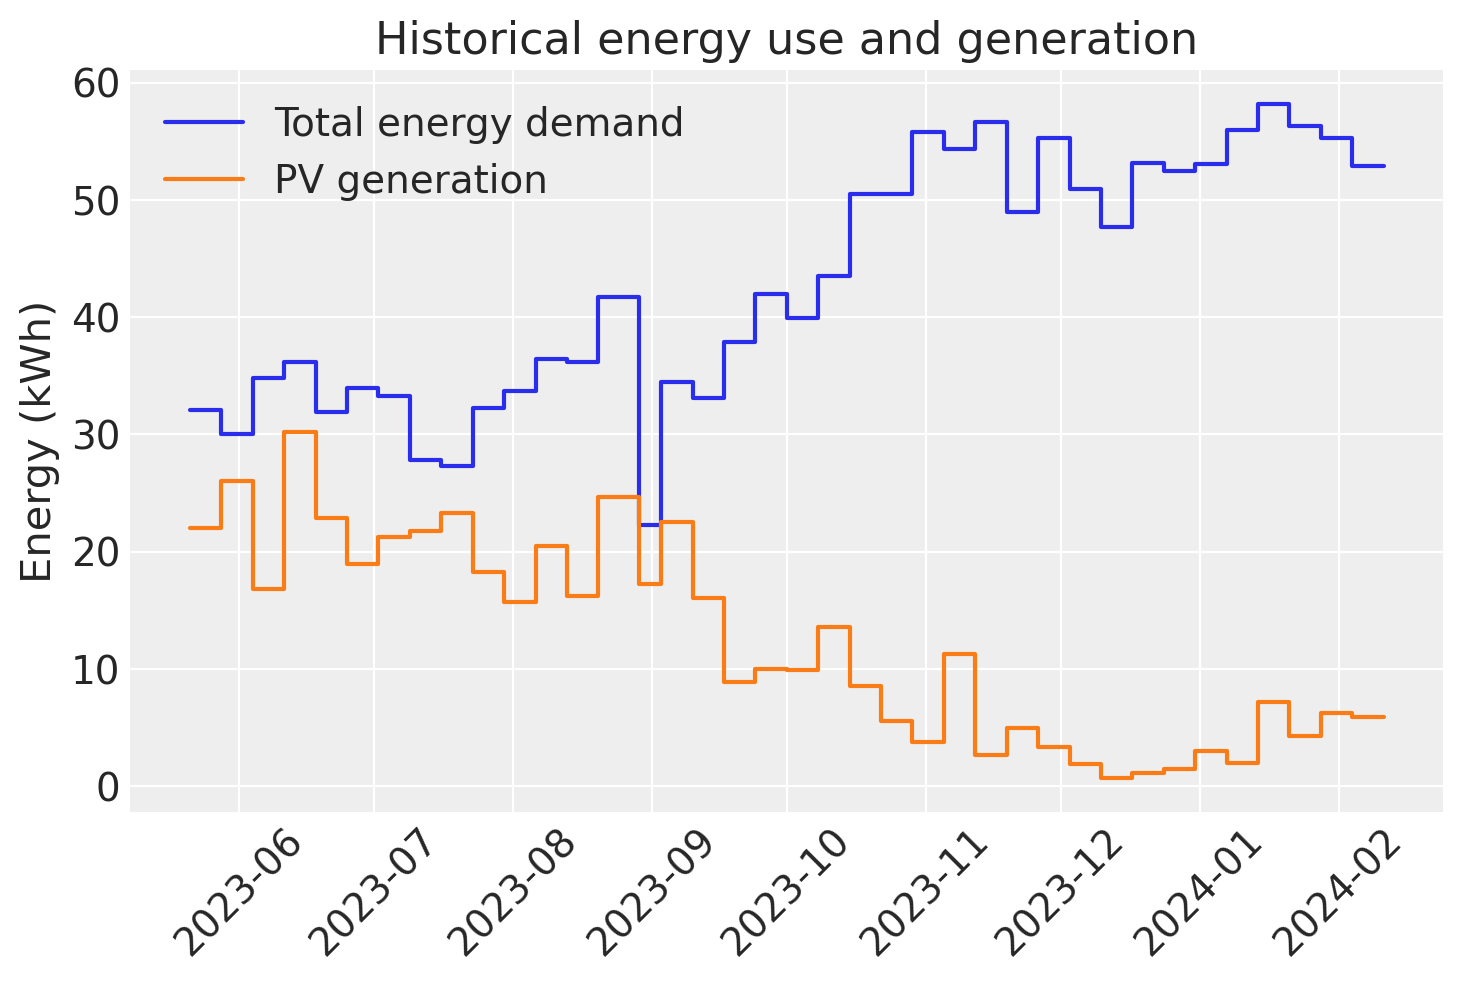

In [12]:
fig, ax = plt.subplots()

ax.step(df.index, df["total_demand"].diff(), label="Total energy demand")
ax.step(df.index, df["pv_gen"].diff(), label="PV generation")
plt.legend()
plt.xticks(rotation=45)
ax.set(title="Historical energy use and generation", ylabel="Energy (kWh)");

### Forecasting PV generation

We will use a simple parametric equation to fit the PV generation data. This will incorporate our knowledge of the physical system and allow us to forecast the PV generation into the future.

TODO: FIND PARAMETRIC EQUATION

### Forecasting the energy demand

### The forecasted costs

Let's put that together to generate a forecast of the costs of the status quo scenario into the future.

## Forecasting cost of the house battery scenario into the future


### The house battery scenario
As we've said, there are many different plausible scenarios here depending on the capacity of the battery in kWh, the way in which it is used, and the choice of tariff. In this section we will outline a simple but realistic scenario.

#### Initial costs

#### Battery capacity

10 kWh usable capacity

#### Round trip efficiency


#### Tariff


#### Battery use strategy

We will focus on load shifting where we charge the battery at the cheaper overnight rate with the aim of using that energy during the day. In an ideal day, we would be able to completely avoid importing from the grid during the regular day rate. Though this is likely to be unrealistic for two reasons. 

Firstly, the battery may not always be able to match the peak instantaneous demand of the house. For example, if we use our electric cooker, hob, have the TV and lighting as well as computer, we may exceed the power output of the battery. Although without historical data on the instantaneous power usage of the house on a miniute by minuite basis, it will be very hard to estimate how much grid import may happen at peak times.

Secondly, the battery may not always have sufficient charge to meet the daily demand of the house. This could happen if:
* the battery were not fully charged overnight for example
* if the total demand of the house was uncharachteristically high


## Estimating the time to break even

Now we can compare the costs of the two scenarios and estimate the time to break even. This is the time at which the costs of the two scenarios are equal. After this time, the house battery scenario will be cheaper.

## Authors
- Authored by [Benjamin T. Vincent](https://github.com/drbenvincent) in February 2024

## References
:::{bibliography}
:filter: docname in docnames
:::

## Watermark

In [13]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Sat Feb 17 2024

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.18.1

pytensor: 2.18.1

arviz     : 0.16.1
matplotlib: 3.8.2
numpy     : 1.26.2
pandas    : 2.1.3
pymc      : 5.10.0

Watermark: 2.4.3



:::{include} ../page_footer.md
:::